# Implementation and Comparison of Convolutional Neural Network (CNN) and Local Binary Patterns Histogram (LBPH)

### Authors: Baohui Zhu, Shangrui Xie, Xinyu Liang

## Introduction

Face recognition is a typical research topic in pattern recognition, image analysis, and understanding. Face recognition [1] not only has important theoretical value but also has important practical value in practice, such as case detection, identity recognition, and other fields. However, due to the changes in image acquisition conditions and the changes in the face itself, different photos of individuals are quite different, sometimes even completely different, and the results may be mistaken for photos of different people, which brings difficulties to face recognition. Therefore, improving the accuracy of the face recognition system is one of the important goals of researchers.


Face feature extraction is very important to face recognition system so finding an effective feature to describe a face is the key to face recognition. Principal Component Analysis (PCA) [2], Linear Discriminant Analysis (LDA) and others in face recognition describe the face image from a global perspective, which can better extract the global features of the image but is susceptible to the influence of light and location. Local binary mode (LBP) was first proposed by Ojala [3], which is not sensitive to light and can well extract local texture features of images. In recent years, LBP has been widely used in texture classification, face image analysis, and other fields.


CNN is mainly used to identify displacement, scaling and other forms of distortion-invariant two-dimensional graphics. Since the feature detection layer of CNN learns from training data, it avoids explicit feature extraction while learning implicitly from training data when using CNN. Moreover, since the weights of neurons on the same feature map are the same, the network can learn in parallel, which is also a major advantage of the convolutional network over the network where neurons are connected to each other. Convolution weights of neural network with its local Shared special structure in terms of speech recognition and image processing has its unique superiority, its layout is closer to real biological neural networks, a weight sharing reduces the complexity of the network, especially the multi-dimensional network input vector image can directly input this feature to avoid the data in the process of feature extraction and classification the complexity of the reconstruction

## Running Dependencies

You need to install the opencv, keras and tensorflow.

## Imports:

In [45]:
import os
import sys
import shutil
from pathlib import Path  
import numpy as np
import cv2
import numpy as np
import pandas as pd
import random
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from keras.optimizers import SGD
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import models

# these are used for displaying images in this notebook
from IPython.display import Image
from IPython.core.display import HTML

## Data File

The image data we used is LFW Face Database: http://vis-www.cs.umass.edu/lfw/

The data set contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured. However, many people only have one face image and cannot be a training data set. Therefore, we selected people who have more than 30 face images as training data set.

In [ ]:
dir_path = "./face"
g = os.walk(dir_path) 

for path,dir_list,file_list in g:  
    for dir_name in dir_list:
#        print(os.path.join(path, dir_name))    
        p = os.path.join(path, dir_name)
        if len(list(Path(p).iterdir())) >= 30 and p!="./face\lfw":
            print(p)
            print(len(list(Path(p).iterdir())))
            if not os.path.exists(os.path.join(dir_path, "train")):
                os.makedirs(os.path.join(dir_path, "train"))
            shutil.move(path+"/"+dir_name ,"./face/train")  

## Image Preprocessing

This is a function for resizing images size to 64*64, we will use it before using thes images to train or predict.

In [3]:
IMAGE_SIZE = 64 
def resize_image(image, height = IMAGE_SIZE, width = IMAGE_SIZE):
    top, bottom, left, right = (0,0,0,0)
    
    h, w, _ = image.shape
    longest_edge = max(h,w)   
    
    # Add padding to shorter edge
    if h < longest_edge:
        dh = longest_edge - h
        top = dh // 2
        bottom = dh - top
    elif w < longest_edge:
        dw = longest_edge - w
        left = dw // 2
        right = dw - left
    else:
        pass 

    BLACK = [0,0,0]
    # add padding
    # cv2.BORDER_CONSTANT: fill colors which are same as edges
    constant = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value = BLACK)
    return cv2.resize(constant, (height, width))

We encoded all images' label and loaded all images and labels dataset.

In [25]:
def read_path(path_name):
    for dir_item in os.listdir(path_name): 
        full_path = os.path.abspath(os.path.join(path_name, dir_item))    
        if os.path.isdir(full_path):
            read_path(full_path)
        else: 
            if dir_item.endswith('.jpg'):
                image = cv2.imread(full_path)
                if image is None: 
                    pass
                else:
                    image = resize_image(image, IMAGE_SIZE, IMAGE_SIZE)
                    images.append(image)
                    labels.append(path_name)
    return images, labels

images = []
labels = []
def load_dataset(path_name):
    images,labels = read_path(path_name)
    images = np.array(images, dtype='float') 
#    print(images.shape) 
    labels = np.array([str(label) for label in labels])
    temp = []
    for file_path in labels:
        name = file_path.split("\\")[-1]
        temp.append(name)
        
    names = pd.DataFrame(temp, columns=['name'])
    le = LabelEncoder().fit(names['name'])
    labels = le.transform(names['name'])
    nameEncode = pd.DataFrame(columns=['name', 'encode'])
    nameEncode['name'] = names['name'].values
    nameEncode['encode'] = labels
    nameEncode.drop_duplicates(keep='first', inplace=True)
    return images, labels, nameEncode

After we load face images, we need to separate them as training and testing dataset.

In [6]:
def load(path_name, img_rows = IMAGE_SIZE, img_cols = IMAGE_SIZE, img_channels = 3):

    images, labels, names = load_dataset(path_name)

    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2, random_state = random.randint(0, 100))

    if K.image_data_format == 'channel_first': 
        train_images = train_images.reshape(train_images.shape[0],img_channels, img_rows, img_cols)
        test_images = test_images.reshape(test_images.shape[0],img_channels, img_rows, img_cols)
        input_shape = (img_channels, img_rows, img_cols)
    else:
        train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, img_channels)
        test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, img_channels)
        input_shape = (img_rows, img_cols, img_channels)

    print(train_images.shape[0], 'train samples')
    print(test_images.shape[0], 'test samples')
        
    #normalization
    train_images /= 255
    test_images /= 255
        
    return train_images, test_images, train_labels, test_labels, input_shape, names

In [26]:
train_images, test_images, train_labels, test_labels, input_shape, names = load('./face/train')

1896 train samples
474 test samples


##  Convolutional Neural Network

### What is Convolutional Neural Network

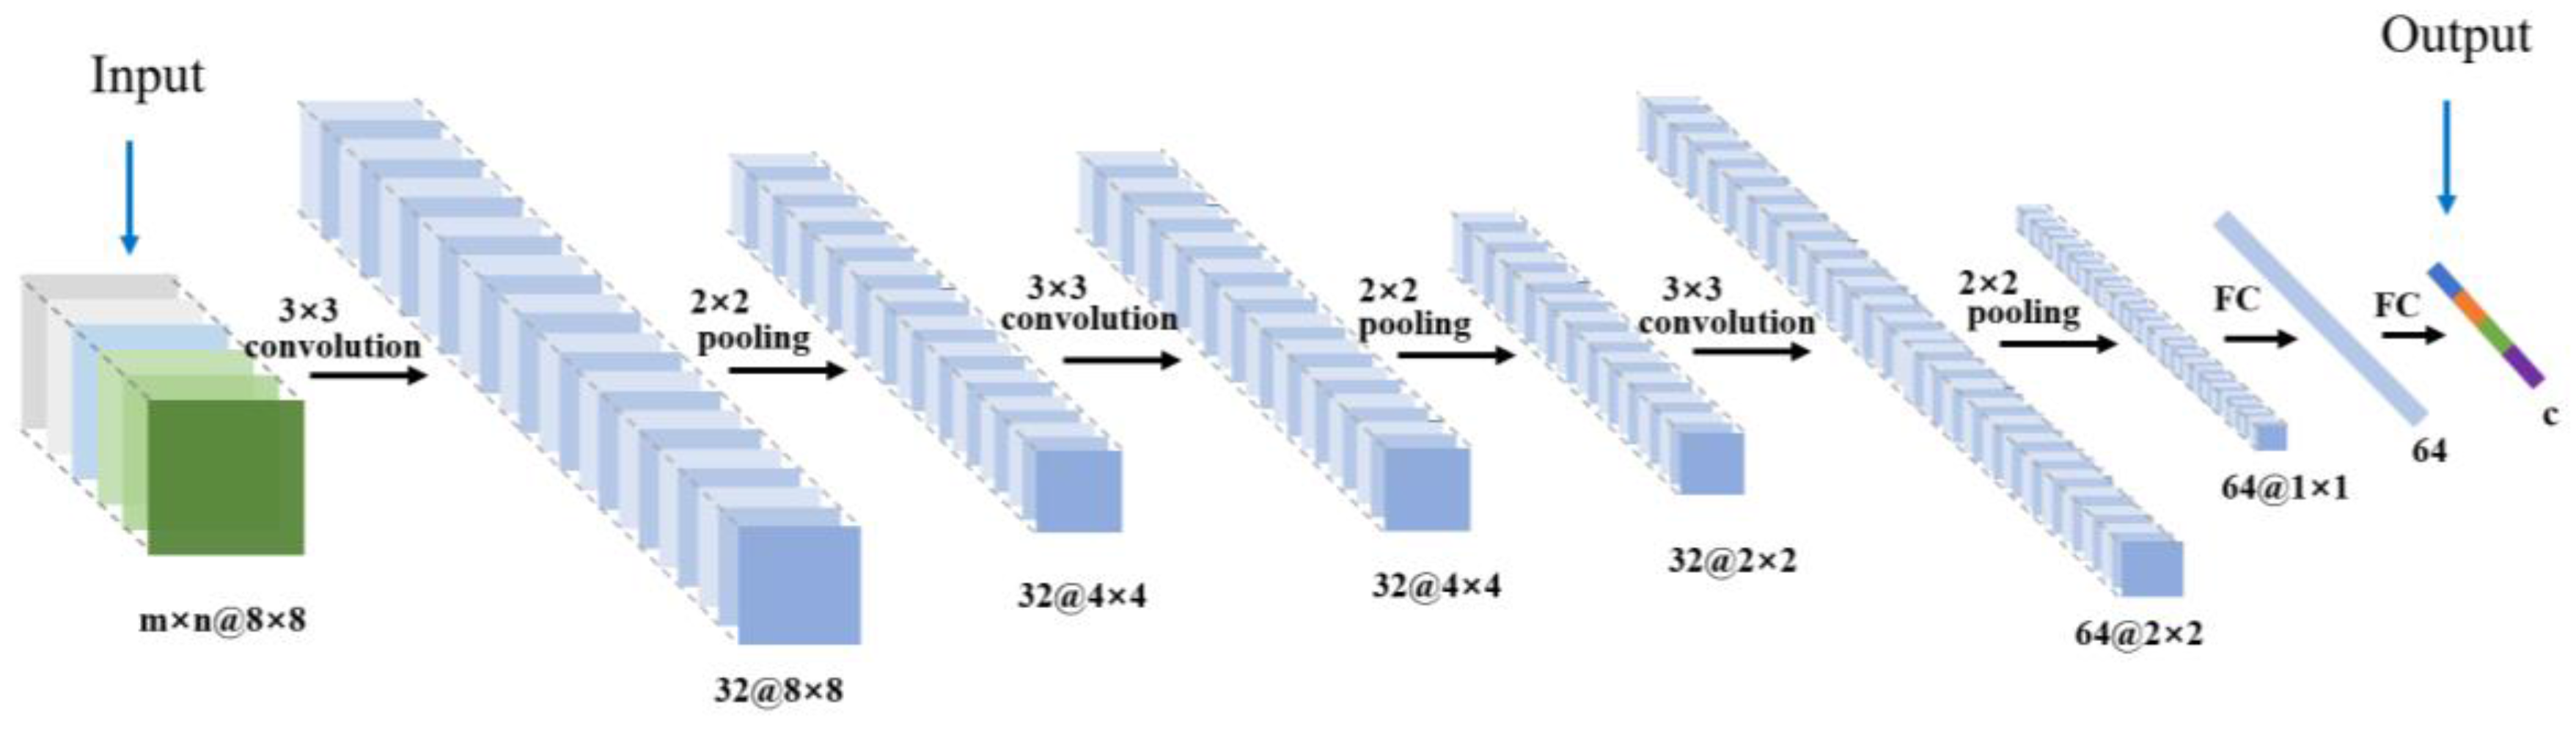

In [46]:
Image(filename = ".images/cnn.png")

A convolutional neural network (CNN) is a type of artificial neural network used in image recognition and processing that is specifically designed to process pixel data.

from https://en.wikipedia.org/wiki/Convolutional_neural_network

## Build a CNN model

Using keras module to train a model.

We used several convolutional 2D layers with relu, maxpooling and dropout, and 2 dense layers with relu, batch normalization and dropout. The output layer is 34 labels output with softmax. The optimizer is adam and loss function is sparse categorical crossentropy.

Because training model costs lots of time, we saved the model in "model" folder after training model.

The following link is my personal colab project, which could use a GPU for building the model.
https://colab.research.google.com/drive/1sPlEkV21WdTQD8cptkef91yWq9Kw22xK

In [30]:
def build_model(x_train, y_train, input_shape, face_classes = 34, batch_size = 128, epochs = 30, data_augmentation = True, valid_data=None):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3),strides=(1, 1), activation='relu', input_shape = input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    model.add(Dropout(0.2))
  
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
        
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
   
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(face_classes, activation='softmax'))
        
#     file_path = "./model/"
    file_path = "drive/INFO_6105/model"
    file_dir = os.path.dirname(file_path)
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
        
    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    if not data_augmentation:
        model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, shuffle = True)
    else:
        datagen = ImageDataGenerator(rotation_range = 20, width_shift_range  = 0.2, height_shift_range = 0.2, horizontal_flip = True)                           
        model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), steps_per_epoch=len(x_train),epochs = epochs)
    model.save('./model/NN_3.face.model.h5')
    return model

We build model by using GPU, which could help accelerate model training. The following code is for using GPU by CoLab project.

In [ ]:
GPU_RUN = True
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    GPU_RUN = False
    print('GPU device not found. Using CPU !!')
else:
    print('Found GPU at: {}'.format(device_name))
    
if GPU_RUN:
    with tf.device('/gpu:0'):
        model = build_model(train_images, train_labels, input_shape)
else:
    model = build_model(train_images, train_labels, input_shape)
print("Model saved in file: ./model/NN_3.face.model.h5")      

If you want to build model in your envirnment, just run the following code.

In [ ]:
model = build_model(train_images, train_labels, input_shape)

Evaluate is a function for testing the model's perfermance in test dataset.

In [ ]:
score = model.evaluate(test_images, test_labels) 
print("%s: %.3f%%" % (model.metrics_names[1], score[1] * 100))

The following screenshot is the correct accuracy after building the model

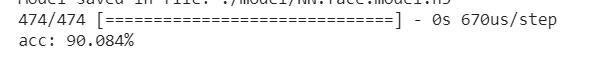

In [44]:
Image(filename = ".images/CNN acc.jpg")

With loading model, we can directly use model and won't spend time on interminable training step.

In [15]:
def load_model():
    try:
        print("Loading model from 'model' file")
        #load model from "model" folder
        new_model = models.load_model('./model/NN_3.face.model.h5')
        new_model.summary()
    except:
        print("Can't load Model")
        print("End Program !!")
        sys.exit()
    return new_model

model = load_model()

Loading model from 'model' file
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 

We can input an image and use this model to recognize who he or she is.

In [7]:
def face_predict(model, image):
    image = resize_image(image)
    image = image.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    image = image.astype('float32') 
    image /= 255
    result = model.predict(image)
    print('result:', result)
    return result.argmax(axis=-1) 

### Visualizing Model

We ramdomly picked a face image and display it.

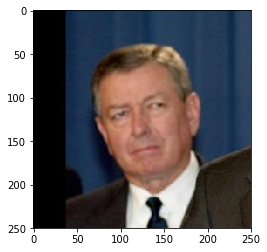

In [55]:
image = cv2.imread('./face/train/John_Ashcroft/John_Ashcroft_0001.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
    
image = resize_image(image)
image = image.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
image = image.astype('float32')
image /= 255   

We got the values of layer activation of the orginal model and showed the visualling image of the first channel from first and second layers.

(1, 62, 62, 32)


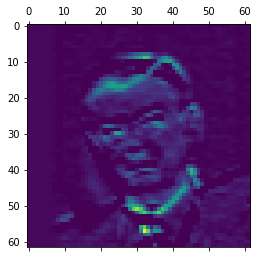

(1, 62, 62, 32)


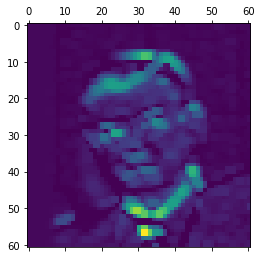

In [71]:
layer_outputs = [layer.output for layer in model.layers[:12]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(image)
    
first_layer_activation = activations[0]
print(first_layer_activation.shape) 
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show() 

secondt_layer_activation = activations[1]
print(first_layer_activation.shape) 
plt.matshow(secondt_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

We ploted all channels' visualling images of first several activation layers of this model.

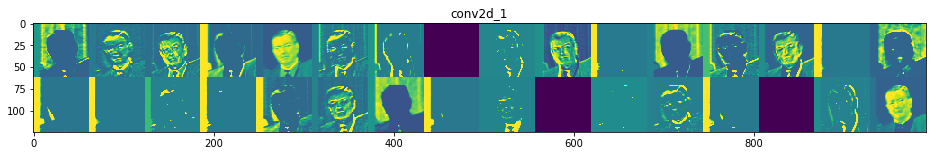

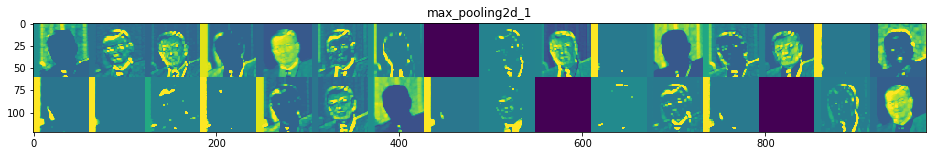

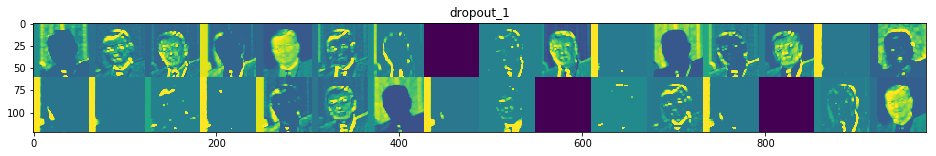

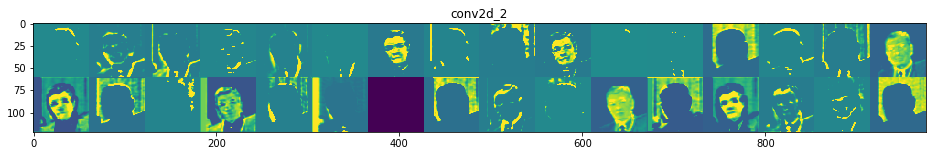

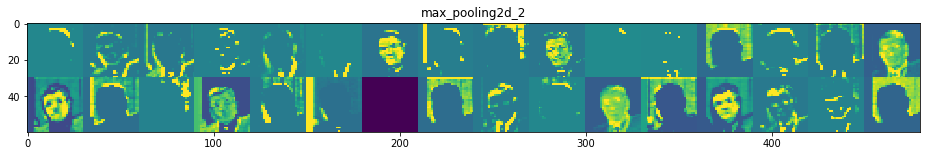

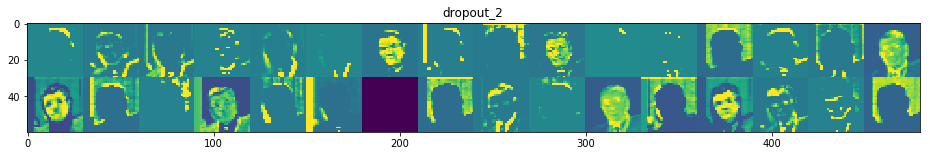

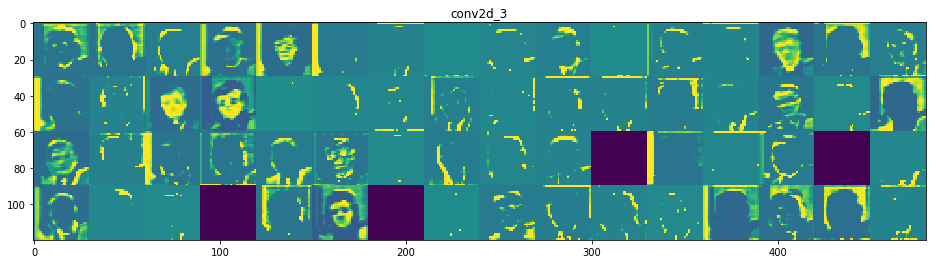

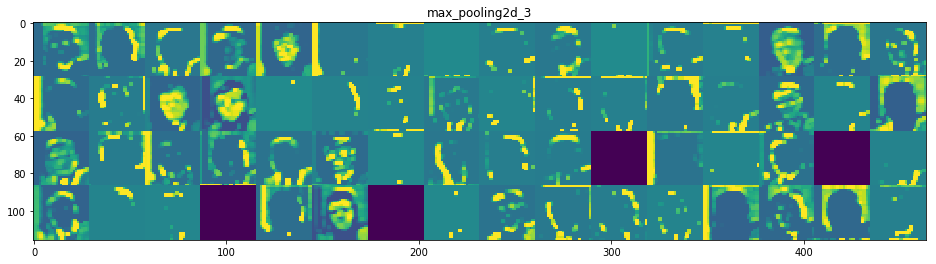

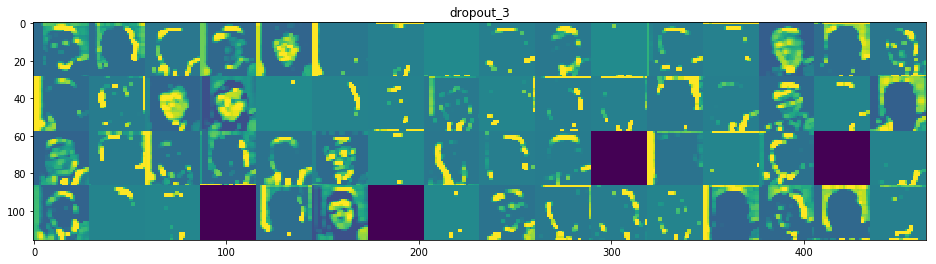

In [73]:
layer_names = []
for layer in model.layers[:9]:
    layer_names.append(layer.name)
    
images_per_row = 16
    
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
plt.show()


We can see whole face and most facial details at the "conv2d_1" layer; we can still recognize who he is. The activation layers contain most facial information. 

Starting from "conv2d_2" layer, we noticed that images starting losing some details but highlighting other parts of details, such as eyes and nose. This phenomenon is more significant in following layers, an image become abstract and only retain a little feature information.

When images were inputted, the model will run its layers, so important information of face features will be retained and irrelated information, like background and clothes, will be ignored and gave up. Therefore, the model will receive more related information of important facial features in higher level layers, and classify images with this information.

### CNN Predict Result

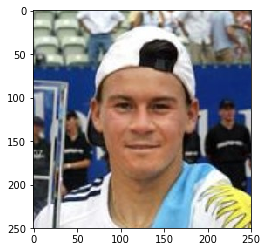

result: [[4.0370212e-03 7.8032826e-07 4.4045702e-02 7.5837893e-06 2.2742615e-05
  3.9950196e-06 8.1902081e-06 2.3784563e-10 5.5442506e-06 1.0758594e-06
  3.2100621e-01 6.0325509e-01 1.0417468e-08 7.5813309e-06 1.1734722e-06
  6.8127670e-11 7.7276200e-05 6.2944478e-06 2.5066044e-13 2.6305694e-02
  2.4370522e-07 2.2602784e-07 1.2161671e-04 3.9733202e-08 9.7043859e-04
  4.3276636e-09 3.3645719e-07 6.9365327e-05 4.4544613e-05 2.6657704e-08
  2.2876372e-09 1.0700264e-07 3.3854253e-09 1.0270230e-06]]

This person is: 
['Guillermo_Coria']


In [27]:
image = cv2.imread("face/train/Guillermo_Coria/Guillermo_Coria_0004.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

result = face_predict(model, image)
print("\nThis person is: ")
print(names[names['encode'].isin(result)]['name'].values)

# LBPH Algorithm 

## What is Local Binary Patterns

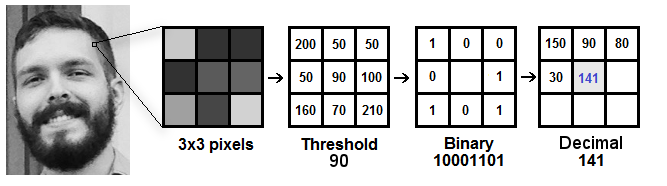

In [47]:
Image(filename = ".images/lbph.png")

Local Binary Pattern (LBP) is a simple yet very efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number.

from 
- https://en.wikipedia.org/wiki/Local_binary_patterns
- https://towardsdatascience.com/face-recognition-how-lbph-works-90ec258c3d6b

In [1]:
import cv2
import os
import numpy as np
from pathlib import Path    
import matplotlib.pyplot as plt
%matplotlib inline
from numba import autojit
from sklearn.model_selection import train_test_split
import random
from sklearn import preprocessing

In this line, we just import the library we needed in the program. For example, OpenCV module, os module (for reading training data directories and paths), numpy,  matplotlib(display our images) and import 

In [2]:
@autojit
def detect_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('C:\\OpenCv\\opencv\\sources\\data\\lbpcascades\\lbpcascade_frontalface.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5);
    if (len(faces) == 0):
        return None, None
    (x, y, w, h) = faces[0]
    return gray[y:y+w, x:x+h], faces[0]

In this line, we use autojit to speed up the function by using GPU.  And use opencv.cvtcolor to convert the image into gray to make it more robust. Use opencv model to cascadeclassifier, to extract the face part of the image to save the time in lbpg model.  If there is no face, we just return None. But if there are faces, we would pick out the first one in the faces array to make it as the main face in this image. 

In [4]:
@autojit
def prepare_training_data(data_folder_path):
    dirs = os.listdir(data_folder_path)
    faces = []
    labels = []
    for dir_name in dirs:
        label = dir_name
        subject_dir_path = data_folder_path + "/" + dir_name
        subject_images_names = os.listdir(subject_dir_path)
        if len(subject_images_names)<30:
            continue
        for image_name in subject_images_names:
            image_path = subject_dir_path + "/" + image_name
            image = cv2.imread(image_path) 
            #cv2.imshow("Training on image...", image)
            #cv2.waitKey(100)
            face, rect = detect_face(image)
            
            if face is not None:
                #add face to list of faces
                faces.append(face)
                #add label for this face
                labels.append(label)
            
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cv2.destroyAllWindows()
   
    return faces, labels

###### This function will read all persons' training images, detect face from each image, and will return two lists of exactly same size, one list of faces and another list of labels for each face.
###### ------STEP-1--------
      use "dir" to get the directories (one directory for each subject) in data folder
      use "faces[]" to list to hold all subject faces
      use "labels[]" to list to hold labels for all subjects
###### ------STEP-2--------
      extract label number of subject from dir_name 
      format of dir name = slabel
      build path of directory containin images for current subject subject
      sample subject_dir_path = "./training-data/lfw"
      use "subject_images_names" to get the images names that are inside the given subject directory
###### ------STEP-3--------
       use the for loop "for image_name in subject_images_names:" togo through each image name, read image, detect face and add face to list of faces.
       build image path by "image_path" and sample image path = training-data/lfw/sample.jpg
       use "image" to read image from the "image_path"
       display an image window to show the image by cv2.imshow()
       use "detect_face(image)" function to get the face in the image.
###### ------STEP-4--------
       For the purpose of this tutorial, we will ignore faces that are not detected(empty face). And put the faces and labels into the array.

In [5]:
print("Preparing data...")
faces, labels = prepare_training_data("./training-data/lfw")
print("Data prepared")
print("Total faces: ", len(faces))
print("Total labels: ", len(labels))

Preparing data...
Data prepared
Total faces:  1971
Total labels:  1971


In [6]:
labels_reshape = np.reshape(labels, (-1,1)) 
faces_train,faces_test,labels_train,labels_test = train_test_split(faces, labels, test_size = 0.2, random_state = random.randint(0, 100))

To get the trainning model train the data easy to just reshape the data. 
And use the the train_test_split to split the faces and labels into train and test parts randomly.

In [7]:
le = preprocessing.LabelEncoder()
le.fit(labels_reshape)
labels_encode_train= le.transform(labels_train)

E:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Use LabelEncoder to change the label into 0 to n, which can help you get a better trainning result.

In [8]:
#train our face recognizer of our training faces
@autojit
def train(faces,labels_encode):
    face_recognizer = cv2.face.LBPHFaceRecognizer_create(radius = 1,neighbors = 12,grid_x = 4,grid_y = 4)
    face_recognizer.train(faces, labels_encode)
    return face_recognizer
face_recognizer = train(faces_train,labels_encode_train)

##### Get the face recognizer model by use the data.
##### And convey the data of model from the function to the face_recognizer parameter. 

In [9]:
def draw_rectangle(img, rect):
    (x, y, w, h) = rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
def draw_text(img, text, x, y):
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)

##### draw_rectangle by using function to draw rectangle on image ,according to given (x, y) coordinates and given width and heigh
###### function to draw text on give image starting from passed (x, y) coordinates. 

In [10]:
def predict(test_img):
    img = test_img.copy()
    face, rect = detect_face(img)
    label= face_recognizer.predict(face)
    print(label)
    draw_rectangle(img, rect)
    if(label[0]!=-1):
        text = le.inverse_transform([label[0]])[0]
    else:
        text = "Cannot find"  
    draw_text(img, text, rect[0], rect[1]-5)
    
    return img

##### This function recognizes the person in image passed and draws a rectangle around detected face with name of the  subject.
##### use img to make a copy of the image as we don't want to chang original image
##### use detect_face function to detect face from the image
##### predict the image using our face recognizer by use the face_recognizer model and get the output by label
##### get name of respective label returned by face recognizer (label_text = labels_encode[label[0]]) and draw a rectangle around face detected
##### draw name of predicted person

In [11]:
def test(faces,labels_encode):
    total = 0
    matches = 0
    for i in range(len(faces)):
        label_predict = face_recognizer.predict(faces[i])
        total += 1
        if labels_encode[i] == label_predict[0]:
            matches += 1
            
    print("Total accuracy is :"+str(matches/total))
    return None

 Use this function to calculate the number of predictions that match the original labels to get the accuracy.

In [12]:
labels_encode_test = le.transform(np.reshape(labels_test, (-1,1)) )
test(faces_test,labels_encode_test)

E:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Total accuracy is :0.5974683544303797


 Just reshape the test data to make the check of accuracy easier.
 In this line, the test function give us the result of the preduiction, the original data, and the outcome of the accuracy.

Predicting images...
(25, 12.65790070895928)
(5, 13.348393218258636)
Prediction complete


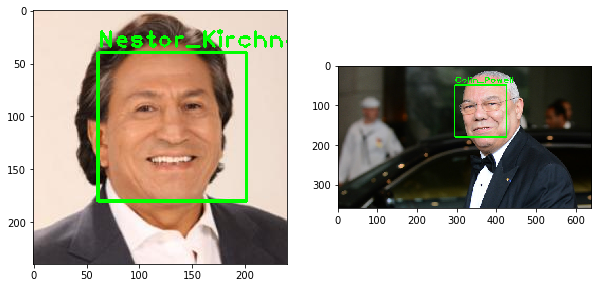

In [13]:
print("Predicting images...")

#load test images
test_img1 = cv2.imread("training-data/testdata/Alejandro_Toledo/Alejandro_Toledo_test_0002.jpg")
test_img2 = cv2.imread("training-data/s1/Colin_Powell_test3.jpg")
#perform a prediction
predicted_img1 = predict(test_img1)
predicted_img2 = predict(test_img2)
print("Prediction complete")

#create a figure of 2 plots (one for each test image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#display test image1 result
ax1.imshow(cv2.cvtColor(predicted_img1, cv2.COLOR_BGR2RGB))

#display test image2 result
ax2.imshow(cv2.cvtColor(predicted_img2, cv2.COLOR_BGR2RGB))

#display both images
cv2.imshow("Tom cruise test", predicted_img1)
cv2.imshow("Shahrukh Khan test", predicted_img2)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
cv2.destroyAllWindows()

In this line, we just give out two example of prediction.

## Conclusion

- LBPH model accuracy: 59.74%
- CNN model accuracy: 90.084%

Training CNN model cost much more time than LBPH model, and it is worth because CNN model works much better than LBPH model. But we noticed that LBPH model can retain images features better, especially some unconspicuous but important features. CNN model will focus on important features and classify them accurately but ignore other features.

Further Work:
Combine LBPH model and CNN model as one model, which should work better than a single model. What we attempt to do is using LBPH algorithm replacing the max-pooling layer.

## Citations

##### [1]  https://towardsdatascience.com/face-recognition-how-lbph-works-90ec258c3d6b
##### [2]  https://en.wikipedia.org/wiki/Local_binary_patterns
##### [3]  https://docs.opencv.org/2.4.13.7/modules/contrib/doc/facerec/facerec_tutorial.htmlThis 
##### [4]  https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
##### [5]  https://keras.io/examples/cifar10_cnn/
##### [6]  https://github.com/seathiefwang/FaceRecognition-tensorflow
##### [7]  https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb

## License

Copyright 2019 Xinyu Liang, Shangrui Xie, Baohui Zhu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/3.0/us/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/">Creative Commons Attribution 3.0 United States License</a>.